# Stroke Disease Classification
*by: [Rifqi Novandi](https://github.com/rifqinvnd)*

## Background
In this machine learning project, the overall topic that will be resolved is in the field of stroke health, where it will try to predict the possibility of a stroke in a person with certain conditions based on several factors including: age, certain diseases (hypertension, heart disease), smoking, etc.

## 1. Install and import required library

In [1]:
# install the newest scikit-learn library

!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [38]:
# library for prepare the dataset
import os
import zipfile

# library for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# library for data processing
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# library for modeling
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, StratifiedKFold

# library for model evaluation
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

## 2. Data preparation
### 2.1 Prepare Kaggle username and key

In [3]:
# menyiapkan kredensial environment Kaggle

os.environ['KAGGLE_USERNAME'] = 'rifqinovandi'
os.environ['KAGGLE_KEY'] = '61655b112a6218032cc7743aab07e371'

### 2.2 Download and preprocess the dataset

In [4]:
# Download the dataset with Kaggle CLI
!kaggle datasets download -d fedesoriano/stroke-prediction-dataset

  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 48.4MB/s]


In [5]:
# Extract zip file to CWD
files = "/content/stroke-prediction-dataset.zip"
zip = zipfile.ZipFile(files, 'r')
zip.extractall('/content')
zip.close()

## 3. Data Understanding
### 3.1 Read data with pandas

In [6]:
df = pd.read_csv('/content/healthcare-dataset-stroke-data.csv')
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


### 3.2 Explore Dataset information

In [7]:
# check dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [8]:
# check dataset shape
df.shape

(5110, 12)

In [9]:
# check missing value of the data
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [10]:
# describe numeric column
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### 3.3 Data Visualization
#### 3.3.1 Check dataset target

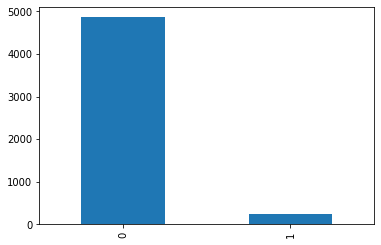

In [11]:
df['stroke'].value_counts().plot(kind='bar')

#### 3.3.2 Check datatype of the column

In [12]:
cats = list(df.select_dtypes(include=['object','bool']) )
nums = list(df.select_dtypes(include=['int64','float64']))
print(cats)
print(nums)

['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']


In [13]:
# classify data for the encoding
encoder = []
onehot = []

for col in cats:
   if len(df[col].unique()) == 2:
        encoder.append(col)
   else:
        onehot.append(col)

print(encoder)
print(onehot)

['ever_married', 'Residence_type']
['gender', 'work_type', 'smoking_status']


In [14]:
df_labencoded = df.copy()

for col in encoder:
    df_labencoded[col] = df_labencoded[col].astype('category').cat.codes
df_labencoded.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,1,Private,1,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,1,Self-employed,0,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,1,Private,0,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,1,Private,1,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,1,Self-employed,0,174.12,24.0,never smoked,1


In [15]:
# check feature correlation to the target
df_labencoded.corr().round(2)

,id,age,hypertension,heart_disease,ever_married,Residence_type,avg_glucose_level,bmi,stroke
id,1.00,0.00,0.00,-0.00,0.01,-0.00,0.00,0.00,0.01
age,0.00,1.00,0.28,0.26,0.68,0.01,0.24,0.33,0.25
hypertension,0.00,0.28,1.00,0.11,0.16,-0.01,0.17,0.17,0.13
heart_disease,-0.00,0.26,0.11,1.00,0.11,0.00,0.16,0.04,0.13
ever_married,0.01,0.68,0.16,0.11,1.00,0.01,0.16,0.34,0.11
Residence_type,-0.00,0.01,-0.01,0.00,0.01,1.00,-0.00,-0.00,0.02
avg_glucose_level,0.00,0.24,0.17,0.16,0.16,-0.00,1.00,0.18,0.13
bmi,0.00,0.33,0.17,0.04,0.34,-0.00,0.18,1.00,0.04
stroke,0.01,0.25,0.13,0.13,0.11,0.02,0.13,0.04,1.00


AxesSubplot(0.125,0.125;0.62x0.755)
AxesSubplot(0.125,0.125;0.62x0.755)
AxesSubplot(0.125,0.125;0.62x0.755)


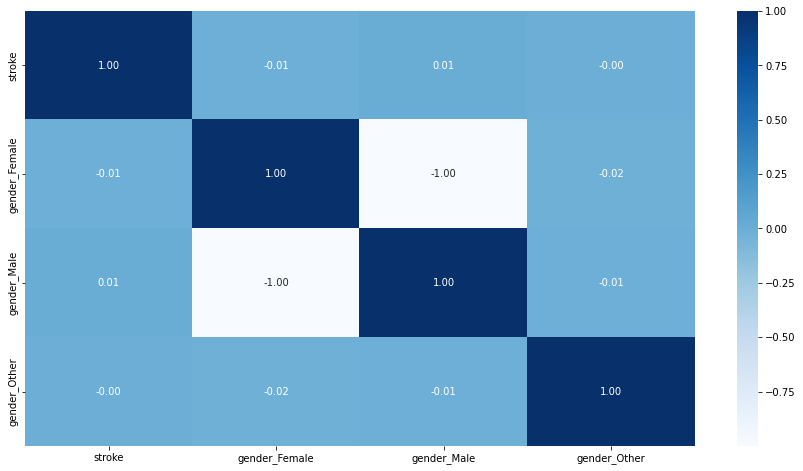

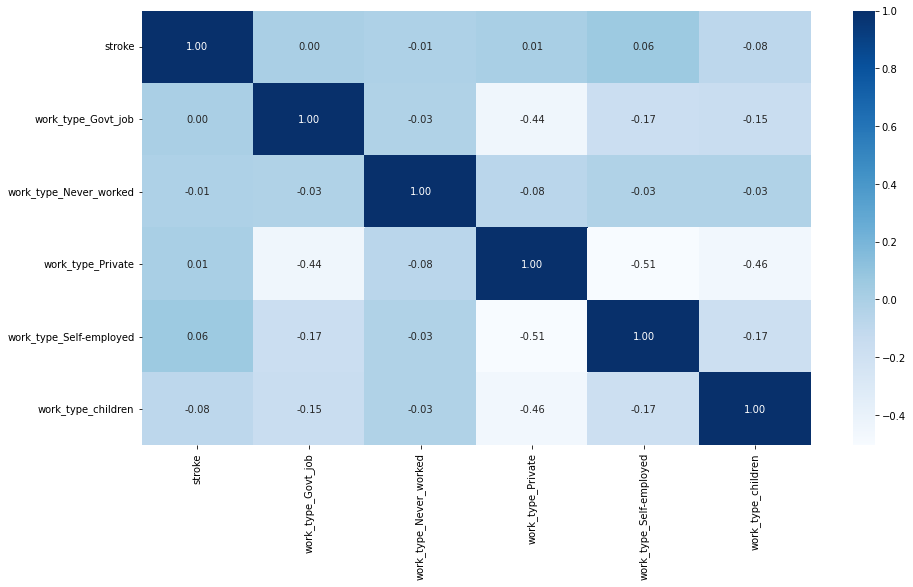

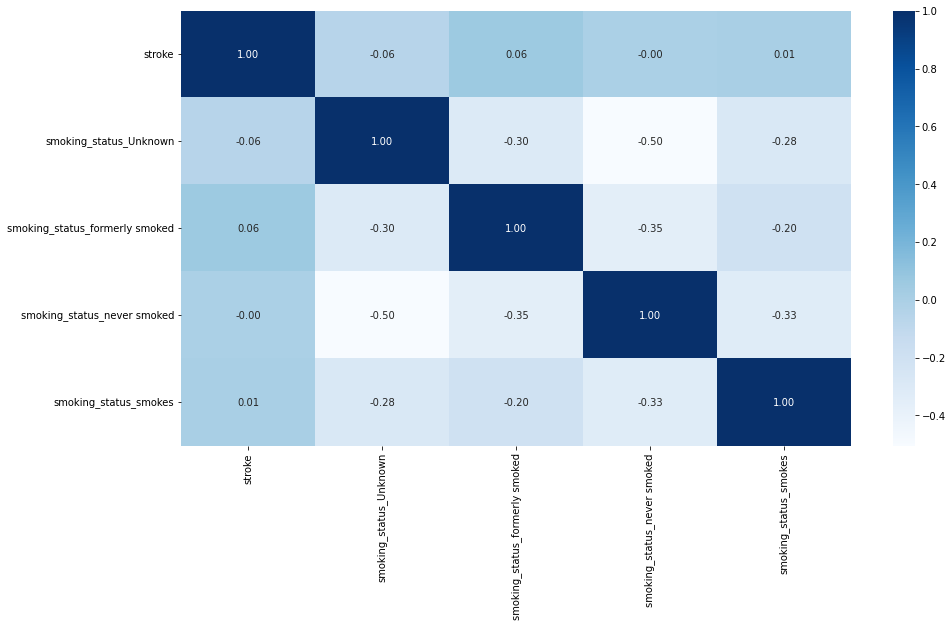

In [16]:
# visualize feature correlation to the target
for col in onehot:
    df_loop = df_labencoded[[col,'stroke']].copy()
    onehots = pd.get_dummies(df_loop[col], prefix=col)
    df_loop = df_loop.join(onehots)
    plt.figure(figsize=(15, 8))
    print(sns.heatmap(df_loop.corr(), cmap='Blues', annot=True, fmt='.2f'))

## 4. Data Preparation
### 4.1 Handling missing values with mean subtitution

In [17]:
df['bmi'].fillna(df['bmi'].mean(), inplace=True)

In [18]:
# recheck missing value
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [19]:
# check duplicated data
duplicate = df.duplicated()
df[duplicate].sum()

id                   0.0
gender               0.0
age                  0.0
hypertension         0.0
heart_disease        0.0
ever_married         0.0
work_type            0.0
Residence_type       0.0
avg_glucose_level    0.0
bmi                  0.0
smoking_status       0.0
stroke               0.0
dtype: float64

### 4.2 Remove unnecessary column

In [20]:
df = df.drop(['id'], axis=1)
nums.remove('id')
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


### 4.3 Remove outliers of the dataset

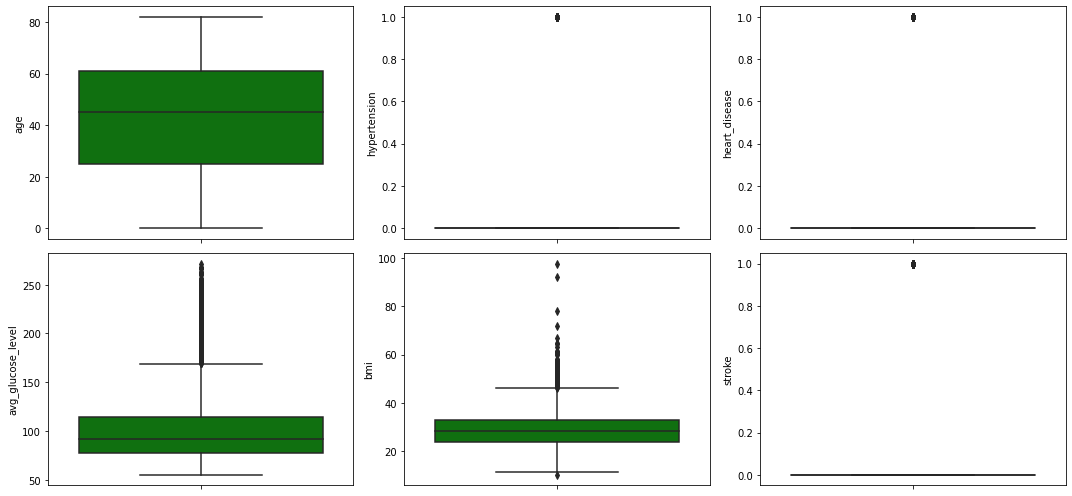

In [21]:
plt.figure(figsize=(15, 7))
for i in range(0, len(nums)):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[nums[i]],color='green',orient='v')
    plt.tight_layout()

In [22]:
outlier = ['avg_glucose_level', 'bmi']

In [23]:
Q1 = df[outlier].quantile(0.25)
Q3 = df[outlier].quantile(0.75)
IQR = Q3 - Q1
df = df[~((df[outlier]<(Q1-1.5*IQR))|(df[outlier]>(Q3+1.5*IQR))).any(axis=1)]
df.reset_index(drop=True)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
6,Male,74.0,1,1,Yes,Private,Rural,70.09,27.400000,never smoked,1
7,Female,69.0,0,0,No,Private,Urban,94.39,22.800000,never smoked,1
8,Female,59.0,0,0,Yes,Private,Rural,76.15,28.893237,Unknown,1
9,Female,78.0,0,0,Yes,Private,Urban,58.57,24.200000,Unknown,1
...,...,...,...,...,...,...,...,...,...,...,...
5105,Female,80.0,1,0,Yes,Private,Urban,83.75,28.893237,never smoked,0
5106,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0
5107,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0
5108,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0


### 4.4 Convert Categorical column to Numerical

In [25]:
# onehot encoding for categorical feature
df = pd.get_dummies(df)
df.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,gender_Female,gender_Male,gender_Other,ever_married_No,...,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
2,80.0,0,1,105.92,32.500000,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
6,74.0,1,1,70.09,27.400000,1,0,1,0,0,...,0,1,0,0,1,0,0,0,1,0
7,69.0,0,0,94.39,22.800000,1,1,0,0,1,...,0,1,0,0,0,1,0,0,1,0
8,59.0,0,0,76.15,28.893237,1,1,0,0,0,...,0,1,0,0,1,0,1,0,0,0
9,78.0,0,0,58.57,24.200000,1,1,0,0,0,...,0,1,0,0,0,1,1,0,0,0


### 4.5 Pre Modeling Steps

In [27]:
# separate feature and target
X = df.drop(columns = ['stroke'])
y = df['stroke']

In [32]:
# using SMOTE Techniqe
sm = SMOTE(random_state=111)
X_sm , y_sm = sm.fit_resample(X,y)

print(f'''Shape of X before SMOTE:{X.shape}
Shape of X after SMOTE:{X_sm.shape}''',"\n\n")

print(f'''Target Class distributuion before SMOTE:\n{y.value_counts(normalize=True)}
Target Class distributuion after SMOTE :\n{y_sm.value_counts(normalize=True)}''')

Shape of X before SMOTE:(4391, 21)
Shape of X after SMOTE:(8452, 21) 


Target Class distributuion before SMOTE:
0    0.962423
1    0.037577
Name: stroke, dtype: float64
Target Class distributuion after SMOTE :
1    0.5
0    0.5
Name: stroke, dtype: float64


### 4.7 Split train data and test data

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X_sm,
    y_sm,
    test_size = .2,
    random_state = 111)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6761, 21), (6761,), (1691, 21), (1691,))

### 4.8 Normalize data with StandardScaler

In [34]:
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

## 5. Machine Learning Modeling

### 5.1 Using K-Nearest-Neighbors-Classifier

In [42]:
# Create simple model
baseline_model = KNeighborsClassifier()
baseline_model.fit(X_train, y_train)

KNeighborsClassifier()

In [43]:
# Test model with test data
y_pred = baseline_model.predict(X_test)

In [44]:
# Simple model report
acc = accuracy_score(y_test, y_pred)
print('Testing-set Accuracy score is:', acc)
print('Training-set Accuracy score is:',accuracy_score(y_train,baseline_model.predict(X_train)))

baseline_report = classification_report(y_test, y_pred, output_dict=True, target_names=['No Stroke', 'Stroke'])
pd.DataFrame(baseline_report).transpose()

Testing-set Accuracy score is: 0.9751626256652868
Training-set Accuracy score is: 0.9782576541931667


,precision,recall,f1-score,support
No Stroke,0.969586,0.979115,0.974328,814.000000
Stroke,0.980437,0.971494,0.975945,877.000000
accuracy,0.975163,0.975163,0.975163,0.975163
macro avg,0.975012,0.975305,0.975136,1691.000000
weighted avg,0.975214,0.975163,0.975166,1691.000000


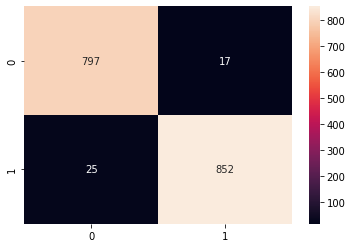

In [45]:
# Confussion matrix
baseline_cf = confusion_matrix(y_test, y_pred)
sns.heatmap(baseline_cf, annot = True, fmt = "d")

### 5.2 Develop the Machine Learning model with Hyperparameter Tuning HalvingGridSearchCV

In [47]:
# set hyperparameter
param_grid = {'n_neighbors': [1, 2],
              'p': [1, 2],
              'weights': ["uniform","distance"],
              'algorithm':["ball_tree", "kd_tree", "brute"],
              }

In [49]:
# Seek for the best hyperparameter with HalvingGridSearchCV
new_param = HalvingGridSearchCV(baseline_model, 
                                param_grid, 
                                cv=StratifiedKFold(n_splits=3, random_state= 123, shuffle=True),
                                resource='leaf_size',
                                max_resources=20,
                                scoring='recall',
                                aggressive_elimination=False).fit(X_train, y_train)

In [50]:
# Result of the hyperparameter tuning
print(f"Best Hyperparameter {new_param.best_estimator_} with score {new_param.best_score_}")

Best Hyperparameter KNeighborsClassifier(algorithm='ball_tree', leaf_size=18, n_neighbors=1, p=1,
                     weights='distance') with score 0.9668555045356385


In [51]:
# Set the model with the best hyperparameter
model = KNeighborsClassifier(algorithm='ball_tree', leaf_size=18, n_neighbors=1, p=1, weights='distance')
model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='ball_tree', leaf_size=18, n_neighbors=1, p=1,
                     weights='distance')

In [53]:
# Test tuned model with test data
y_pred = model.predict(X_test)

In [54]:
# Tuned model report
acc = accuracy_score(y_test, y_pred)
print('Testing-set Accuracy score is:', acc)
print('Training-set Accuracy score is:',accuracy_score(y_train,model.predict(X_train)))

improvement_report = classification_report(y_test, y_pred, output_dict=True, target_names=['No Stroke', 'Stroke'])
pd.DataFrame(improvement_report).transpose()

Testing-set Accuracy score is: 0.9686575990538143
Training-set Accuracy score is: 1.0


,precision,recall,f1-score,support
No Stroke,0.975031,0.959459,0.967183,814.000000
Stroke,0.962921,0.977195,0.970006,877.000000
accuracy,0.968658,0.968658,0.968658,0.968658
macro avg,0.968976,0.968327,0.968594,1691.000000
weighted avg,0.968751,0.968658,0.968647,1691.000000


## 6. Model Evaluation
### 6.1 Matrix comparison between the initial baseline model and the hyperparameter-tuned model

In [56]:
metrics = pd.DataFrame({'accuracy' : [baseline_report['accuracy'], improvement_report['accuracy']],
                        'f1-score_0' : [baseline_report['No Stroke']['f1-score'],improvement_report['No Stroke']['f1-score']],
                        'precision_0' : [baseline_report['No Stroke']['precision'],improvement_report['No Stroke']['precision']],
                        'recall_0' : [baseline_report['No Stroke']['recall'],improvement_report['No Stroke']['recall']],
                        'f1-score_1' : [baseline_report['Stroke']['f1-score'],improvement_report['Stroke']['f1-score']],
                        'precision_1' : [baseline_report['Stroke']['precision'],improvement_report['Stroke']['precision']],
                        'recall_1' : [baseline_report['Stroke']['recall'],improvement_report['Stroke']['recall']]},
                        index=['Model Baseline','Tuned Model'])
multiheader = [('','accuracy'),
               ('No Stroke', 'f1-score'),
               ('No Stroke', 'precision'),
               ('No Stroke', 'recall'),
               ('Stroke', 'f1-score'),
               ('Stroke', 'precision'),
               ('Stroke', 'recall')]
metrics.columns = pd.MultiIndex.from_tuples(multiheader)
metrics

No Stroke                        Stroke            \
                accuracy  f1-score precision    recall  f1-score precision   
Model Baseline  0.975163  0.974328  0.969586  0.979115  0.975945  0.980437   
Tuned Model     0.968658  0.967183  0.975031  0.959459  0.970006  0.962921   

                          
                  recall  
Model Baseline  0.971494  
Tuned Model     0.977195

## Closing
Machine Learning Model to predict stroke in humans can be used because it reaches a recall score of 97.7% which is where this model can predict stroke very well although it still needs to be improved even up to a recall score of 100%.

### References
- Scikit-learn Docummentation: [https://scikit-learn.org/stable/modules/classes.html](https://scikit-learn.org/stable/modules/classes.html)
- Report References: [https://github.com/fahmij8/ML-Exercise/blob/main/MLT-1/MLT_Proyek_Submission_1.ipynb](https://github.com/fahmij8/ML-Exercise/blob/main/MLT-1/MLT_Proyek_Submission_1.ipynb)
- Project: [https://www.kaggle.com/muhamilham/supervised-learning-stroke-prediction](https://www.kaggle.com/muhamilham/supervised-learning-stroke-prediction)